<a href="https://colab.research.google.com/github/Small-Fiend/CUDA_Laboratory/blob/main/MatMult/Matrix_Mult.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import random

import numpy as np
from numba import cuda, int32, jit
from tabulate import tabulate

import time
import datetime

import matplotlib.pyplot as plt

In [2]:
# Расчет будет производиться на блоках элементов TPBxTPB
TPB = 16
# Количество итераций для вычисления среднего затраченного времени
ITER_COUNT = 10

In [3]:
#Функция создания матриц MxM
def create_matrix (M):
  A = np.random.randint(1000, size=(M,M))
  B = np.random.randint(1000, size=(M,M))
  C = np.zeros((M, M), dtype=np.int32)
  return (A, B, C)

In [4]:
M = 100
A, B, C = create_matrix (M)
print("A", A, "\n", "B", B, "\n", "C", C)

A [[734 494 374 ... 414 678 612]
 [683 760 963 ... 969 499 248]
 [227 295 652 ... 688 945 158]
 ...
 [796 470 138 ... 119 866  86]
 [651   7 522 ... 965 104 825]
 [479 247 688 ... 127 990 668]] 
 B [[545 719 560 ... 804  42 998]
 [763 830 878 ... 523 537 604]
 [678 949 203 ...  55 541 611]
 ...
 [497 176 191 ... 537 718 521]
 [551 330 124 ... 656  82 544]
 [959 472 417 ... 946 733  19]] 
 C [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Умножение матриц на CPU

In [5]:
# стартовое время
start_time = datetime.datetime.now() 
C1 = A.dot(B)
# затраченное время
t1 = datetime.datetime.now() - start_time
print(C1)
print ('time:  '+ str(t1)) 

[[30776762 23822841 25102761 ... 26030878 28898853 26593445]
 [27490611 22870581 26229180 ... 24682317 26435996 24518172]
 [27159994 25063168 24907432 ... 26502797 28052044 25911027]
 ...
 [30581637 27504542 29263728 ... 30109648 31739160 30626202]
 [27913397 23408933 24016322 ... 27004157 28560621 27262551]
 [25256259 21219435 23875290 ... 24649112 26804999 23753811]]
time:  0:00:00.002404


In [ ]:
'''def matrix_mult_CPU (matrix1, matrix2, matrix3, M):
    
    for i in range(0, M):
        for j in range(0, M):
            for k in range(0, M):
                matrix3[i][j] += int(matrix1[i][k] * matrix2[k][j])  
    
    return (matrix3)'''

In [ ]:
'''# стартовое время    
start_time = datetime.datetime.now()    
C2 = matrix_mult_CPU(A, B, C, M)
# затраченное время
t2 = datetime.datetime.now() - start_time

print(C2)
print ('time:  '+ str(t2))  '''

[[27907764 24971261 25254942 ... 23439630 23816621 29236771]
 [25076077 23811393 26032762 ... 23387749 23680996 28011036]
 [23816981 24256532 24404123 ... 22603924 22069799 25707786]
 ...
 [24977442 25339732 25366865 ... 22784153 24348815 26750423]
 [24497537 22932350 25141208 ... 24050127 22018084 26314261]
 [28032329 27496579 28237642 ... 26117266 25955740 29954743]]
time:  0:00:03.774863


Умножение матриц на GPU

In [6]:
#Динамический компилятор Cuda
@cuda.jit
def matrix_mult_GPU(d_a, d_b, d_c):
  # определяем массив в общей памяти
  shared_a = cuda.shared.array(shape=(TPB, TPB), dtype=int32)
  shared_b = cuda.shared.array(shape=(TPB, TPB), dtype=int32)

  x, y = cuda.grid(2)
  
  # Набор встроенных функций CUDA используется для идентификации текущего потока выполнения (используются только внутри ядра CUDA или функции устройства)
  t_x = cuda.threadIdx.x
  t_y = cuda.threadIdx.y
  # количество блоков на сетку
  bpg = cuda.gridDim.x  

  # Проверка на выход границы
  if x >= d_c.shape[0] and y >= d_c.shape[1]:
    return

  # каждый поток вычисляет один элемент в итоговой матрице, произведение разбивается на произведения векторов длиной TPB
  tmp = 0.
  for i in range(bpg):
    # загружаем данные в общую память
    shared_a[t_x, t_y] = d_a[x, t_y + i * TPB]
    shared_b[t_x, t_y] = d_b[t_x + i * TPB, y]

    # ожидание окончания предварительной загрузки
    cuda.syncthreads() 
    
    # вычисление в общей памяти
    for j in range(TPB):
      tmp += shared_a[t_x, j] * shared_b[j, t_y]

    # Ожидание окончания вычисления на всех потоках
    cuda.syncthreads()   
  d_c[x, y] = tmp

In [20]:
def body_GPU(grid_size, block_size, d_a, d_b, d_c):
  # Перенос данных в глобальную память GPU
  d_a = cuda.to_device(A)
  d_b = cuda.to_device(B)
  d_c = cuda.to_device(C)

  # вызов ядра
  matrix_mult_GPU[grid_size, block_size](d_a, d_b, d_c)
  # Перенос вывода с устройства на хост
  GPU_C = d_c.copy_to_host()
  return GPU_C


In [23]:
grid_size = (10, 10)
block_size = (16, 16)
# стартовое время
start_time = datetime.datetime.now()    
GPU_C1=body_GPU(grid_size, block_size, A, B, C)
# затраченное время
t3 = datetime.datetime.now() - start_time

print(GPU_C1)
print ('time:  '+ str(t3))

[[48286289 43614415 42041071 ... 42606079 41610623 42667576]
 [40455710 37773229 36033659 ... 37945452 36225442 39646263]
 [45843831 40857970 39947628 ... 40818372 39912680 38720164]
 ...
 [50379171 42406190 41654155 ... 43882078 42135953 43398672]
 [45571325 39780118 39908402 ... 38495392 39106504 42293896]
 [42240131 37671067 40785132 ... 39083905 38460593 39046878]]
time:  0:00:00.007514


In [ ]:
'''grid_size = (10, 10)
block_size = (16, 16)
# стартовое время
start_time = datetime.datetime.now()    

# Перенос данных в глобальную память GPU
d_a = cuda.to_device(A)
d_b = cuda.to_device(B)
d_c = cuda.to_device(C)

# вызов ядра
matrix_mult_GPU[grid_size, block_size](d_a, d_b, d_c)
# Перенос вывода с устройства на хост
GPU_C = d_c.copy_to_host()

# затраченное время
t3 = datetime.datetime.now() - start_time

print(GPU_C)
print ('time:  '+ str(t3))'''

[[47039330 40448661 42254587 ...        0        0        0]
 [40619316 35309316 38255705 ...        0        0        0]
 [48111842 40386128 43165637 ...        0        0        0]
 ...
 [       0        0        0 ...        0        0        0]
 [       0        0        0 ...        0        0        0]
 [       0        0        0 ...        0        0        0]]
time:  0:00:00.515727


In [26]:
result_list = []
# размер матриц по условию от 100x100 до 2000х2000, 
# расчет производится на блоках элементов TPBxTPB (т.е. 16x16)
# Количество итераций для вычисления среднего затраченного времени ITER_COUNT = 10

for bpg in range(10, 140, 15):
  grid_size = (bpg, bpg)
  block_size = (TPB, TPB)
  
  # размер матрицы
  M = bpg * TPB

  correct_result = True
  
  dot_time_sum = 0
  cpu_time_sum = 0
  gpu_time_sum = 0

  for _ in range(ITER_COUNT):
    # создаем матрицы размера М
    A, B, C = create_matrix (M)
   
    # стартовое время
    start = time.time()
    CPU_C = A.dot(B)
    # затраченное время
    dot_time = time.time() - start
    dot_time_sum += dot_time

    # стартовое время
    start = time.time()

    GPU_C2 = body_GPU(grid_size, block_size, A, B, C)
    
    # затраченное время
    gpu_time = time.time() - start
    gpu_time_sum += gpu_time

    # для проверки правильности вычислений на GPU
    correct_result = np.array_equal(GPU_C2, CPU_C)

  res = [M, correct_result, dot_time_sum / ITER_COUNT, gpu_time_sum / ITER_COUNT]
  #print(res)
  result_list.append(res)


In [27]:
print(tabulate(result_list, headers=['Matrix size', 'Correct', 'CPU time', 'GPU time']))

  Matrix size  Correct       CPU time    GPU time
-------------  ---------  -----------  ----------
          160  True        0.00516961  0.00232291
          400  True        0.0957757   0.0071058
          640  True        0.694063    0.0174647
          880  True        1.01174     0.0392471
         1120  True        6.02585     0.0757729
         1360  True       13.4636      0.125926
         1600  True       16.1497      0.185167
         1840  True       21.9112      0.280759
         2080  True       34.0479      0.396888


Визуализируем полученные данные

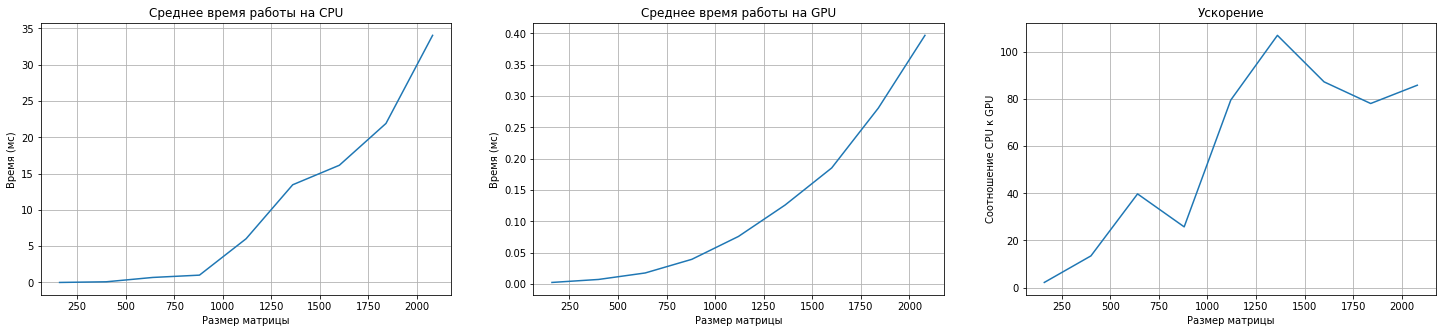

In [28]:
result_matr = np.array(result_list)
plt.figure(figsize=(25, 5))

plt.subplot(1, 3, 1)
plt.title('Среднее время работы на CPU')
plt.plot(result_matr[:, 0], result_matr[:, 2])
plt.xlabel('Размер матрицы')
plt.ylabel('Время (мс)')
plt.grid()

plt.subplot(1, 3, 2)
plt.title('Среднее время работы на GPU')
plt.plot(result_matr[:, 0], result_matr[:, 3])
plt.xlabel('Размер матрицы')
plt.ylabel('Время (мс)')
plt.grid()

plt.subplot(1, 3, 3)
plt.title('Ускорение')
plt.plot(result_matr[:, 0], (result_matr[:, 2]/result_matr[:, 3]))
plt.xlabel('Размер матрицы')
plt.ylabel('Соотношение CPU к GPU')
plt.grid()